<a href="https://colab.research.google.com/github/ANUPRIYAR/ML_Practise/blob/main/machine_translation_beginner_s_guide.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Machine Translation

In this notebook, we're going to perform a Machine Translation (MT) using RNN Model. As part of this MT, we'll train the model to learn ENGLISH-FRENCH sentence pairs from the [dataset](https://www.kaggle.com/devicharith/language-translation-englishfrench) and once trained & ready, our model will accept ENGLISH & translate it to FRENCH.

As always, I will try to keep the notebook clean, well commented & organized. Please do consider it to **UPVOTE** if you find it helpful :-)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Libraries

In [2]:
import collections
from collections import Counter

import helper
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, Sequential
from keras.layers import GRU, Input, Dense, TimeDistributed, Activation, RepeatVector, Bidirectional,LSTM
from keras.layers.embeddings import Embedding
from keras.optimizers import Adam
from keras.losses import sparse_categorical_crossentropy
from keras.callbacks import ModelCheckpoint

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from sklearn.model_selection import train_test_split

from tabulate import tabulate

import gc

# Data

In [3]:
# url = '../input/language-translation-englishfrench/eng_-french.csv'
path = '/content/drive/MyDrive/Deep_learning/eng_-french.csv.zip'
data = pd.read_csv(path, header='infer')

# EDA

In [4]:
#Total Records
print("Total Records: ", data.shape[0])

Total Records:  175621


In [5]:
#Checking for Null/Missing Values
data.isna().sum()

English words/sentences    0
French words/sentences     0
dtype: int64

In [6]:
#Renaming Columns
data = data.rename(columns={"English words/sentences":"Eng", "French words/sentences":"Frn" })

In [7]:
#Randomly Show a English > French sentence
x = np.random.randint(1, data.shape[0])
print("--- Random English - French Sentence --- \n"
      "English Sentence/Word: ", data.Eng[x], "\n"
      "French Sentence/Word: ", data.Frn[x]
     )

--- Random English - French Sentence --- 
English Sentence/Word:  When was that? 
French Sentence/Word:  Quand cela a-t-il eu lieu ?


In [8]:
# Function for word count
def word_count (txt):
    return len(txt.split())

In [9]:
#Applying the Word Count Function to Eng & French Columns
data['Eng_Count'] = data['Eng'].apply(lambda x: word_count(x))
data['Frn_Count'] = data['Frn'].apply(lambda x: word_count(x))

In [10]:
print( '{} English Words'.format(data['Eng_Count'].sum()) ) 
print('{} French Words'.format(data['Frn_Count'].sum()) )
      

1082098 English Words
1177832 French Words


In [11]:
fig = make_subplots(rows=1, cols=2, subplot_titles=("English","French"))

fig.add_trace(
    go.Histogram(x=data['Eng_Count'],histfunc='sum',opacity =0.8,showlegend=False,text='Eng'), row=1,col=1)

fig.add_trace(
    go.Histogram(x=data['Frn_Count'],histfunc='sum', opacity =0.8,showlegend=False,text='Frn'), row=1,col=2)

fig.update_layout(height=600, width=800, title_text="Words Distribution")
fig.show()



# Pre-Process

**Tokenization** - For a neural network to predict on text data, it first has to be turned into data it can understand. Since a neural network is a series of multiplication and addition operations, the input data needs to be number(s). Here we're going to use Kera's **Tokenizer** function to turn each sentence into sequence of words

**Padding** - When batching the sequence of token'd words together, each sequence needs to be the same length. Since sentences are dynamic in length, we can add padding to the end of the sequences to make them the same length. Here we're going to use Kera's **Pad_Sequences** function



In [12]:
#Tokenize Function
def tokenize(x):
    x_tk = Tokenizer(char_level = False)
    x_tk.fit_on_texts(x)
    return x_tk.texts_to_sequences(x), x_tk
    #return x_tk


In [13]:
#Padding Function
def pad(x, length=None):
    if length is None:
        length = max([len(sentence) for sentence in x])
    return pad_sequences(x, maxlen = length, padding = 'post')
    

# Vocabulary Size & Sequence Length (Complete Dataset)

In [14]:
#Tokenize English text & determine English Vocab Size 
eng_seq, eng_tok = tokenize(data['Eng'])
eng_vocab_size = len(eng_tok.word_index) + 1
print("Complete English Vocab Size: ",eng_vocab_size)

#Tokenize French text & determine French Vocab Size 
frn_seq, frn_tok = tokenize(data['Frn'])
frn_vocab_size = len(frn_tok.word_index) + 1
print("Complete French Vocab Size: ",frn_vocab_size)


Complete English Vocab Size:  14532
Complete French Vocab Size:  30661


In [15]:
#Sequence Length (Complete Dataset) 
eng_len = max([len(sentence) for sentence in eng_seq])
frn_len = max([len(sentence) for sentence in frn_seq])

print("English Sequence Length: ",eng_len,"\n",
      "French Sequence Length: ",frn_len)

English Sequence Length:  44 
 French Sequence Length:  55


# Data Split


In [16]:
# split data into train (90%) and test set (10%)
train_data, test_data = train_test_split(data, test_size=0.1, random_state = 0)

# Preparing Train & Test Data

The Training & Test Data contains some unwanted columns & also needed a reset of index

In [17]:
#Drop Columns
train_data = train_data.drop(columns=['Eng_Count', 'Frn_Count'],axis=1)
test_data = test_data.drop(columns=['Eng_Count', 'Frn_Count'],axis=1)

#Re-Index
train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)


# Processing the Training & Test Data

**Note: For the purposes of this notebook/tutorial we're going to consider *English Sentences as Feature/Input* & *French Sentences as Target*.**

In [18]:
# -- Tokenization --

# Training Data
train_X_seq, train_X_tok = tokenize(train_data['Eng'])
train_Y_seq, train_Y_tok = tokenize(train_data['Frn'])

train_eng_vocab = len(train_X_tok.word_index) + 1
train_frn_vocab = len(train_Y_tok.word_index) + 1

# Testing Data
test_X_seq, test_X_tok = tokenize(test_data['Eng'])
test_Y_seq, test_Y_tok = tokenize(test_data['Frn'])

test_eng_vocab = len(test_X_tok.word_index) + 1
test_frn_vocab = len(test_Y_tok.word_index) + 1


# -- Padding --

#Training Data
train_X_seq = pad(train_X_seq)
train_Y_seq = pad(train_Y_seq)

#Testing Data
test_X_seq = pad(test_X_seq)
test_Y_seq = pad(test_Y_seq)



In [19]:
#Tabulate the Vocab Size
tab_data = [["Train", train_eng_vocab, train_frn_vocab],["Test",test_eng_vocab,test_frn_vocab]]
print(tabulate(tab_data, headers=['Dataset','Eng Vocab Size','Frn Vocab Size'], tablefmt="pretty"))


+---------+----------------+----------------+
| Dataset | Eng Vocab Size | Frn Vocab Size |
+---------+----------------+----------------+
|  Train  |     14068      |     29389      |
|  Test   |      6166      |     10502      |
+---------+----------------+----------------+


# Build Model

### Model - RNN with Word Embedding
### Architecture - LSTM


In [20]:
# Define Model

def define_model(in_vocab,out_vocab, in_timesteps,out_timesteps, btch_size):
    
    model = Sequential()
    model.add(Embedding(in_vocab, btch_size, input_length=in_timesteps, mask_zero=True))
    
    model.add(LSTM(btch_size))
    model.add(RepeatVector(out_timesteps))
    model.add(LSTM(btch_size, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    
    return model

In [21]:
# Compile Parameters
batch_size = 64   #batch size
lr = 1e-3          #learning rate

#Model
model = define_model(eng_vocab_size, frn_vocab_size, eng_len, frn_len, batch_size)

#Compile Model
model.compile(loss='sparse_categorical_crossentropy', optimizer = Adam(lr))


# Train Model

We'll train our model for 10 epochs and with a batch size of 64 with a validation split of 10%. 90% of the data will be used for training the model and the rest for evaluating it.

We will also use the ModelCheckpoint() function to save the model with the lowest validation loss.

In [22]:
fn = 'model.h1.MT'
epoch = 2
val_split = 0.1

#Checkpoint
checkpoint = ModelCheckpoint(fn, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

#Train
history = model.fit(train_X_seq, train_Y_seq,
                    epochs=epoch, batch_size=batch_size, validation_split = val_split, callbacks=[checkpoint], 
                    verbose=1)



Epoch 1/2
2223/2223 [==============================] - 153s 64ms/step - loss: 1.8675 - val_loss: 0.8179

Epoch 00001: val_loss improved from inf to 0.81788, saving model to model.h1.MT


INFO:tensorflow:Assets written to: model.h1.MT/assets


INFO:tensorflow:Assets written to: model.h1.MT/assets


Epoch 2/2
2223/2223 [==============================] - 142s 64ms/step - loss: 0.8114 - val_loss: 0.7871

Epoch 00002: val_loss improved from 0.81788 to 0.78706, saving model to model.h1.MT


INFO:tensorflow:Assets written to: model.h1.MT/assets


INFO:tensorflow:Assets written to: model.h1.MT/assets


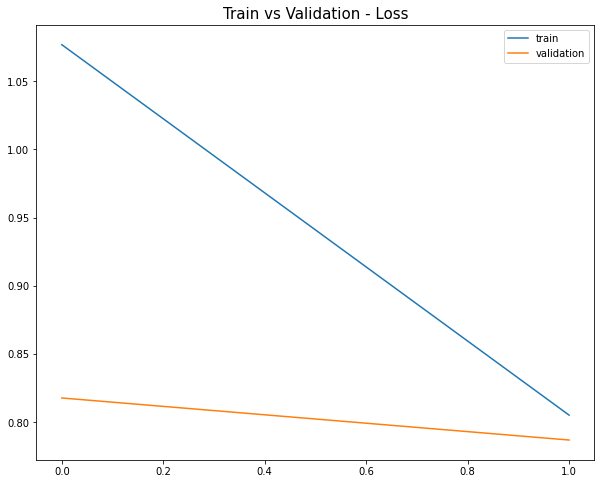

In [23]:
plt.rcParams["figure.figsize"] = (10,8)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.title("Train vs Validation - Loss", fontsize=15)
plt.show()

# Prediction

In [24]:
#Making Prediction
predictions = model.predict(test_X_seq[1:6])[0]

In [25]:
def to_text(logits, tokenizer):

    index_to_words = {id: word for word, id in tokenizer.word_index.items()}
    index_to_words[0] = ''
    return ' '.join([index_to_words[prediction] for prediction in np.argmax(logits, 1)])

In [26]:
print(to_text(predictions, frn_tok))

je ne pas                                                    
